In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import netCDF4
import xarray as xr
import hmp
from pathlib import Path
from mne.io import read_info
from mne import read_epochs
from hmpai.data import StageFinder
from hmpai.training import split_participants_custom
from hmpai.pytorch.utilities import set_global_seed
import os
from tqdm.notebook import tqdm

DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
# info_path = DATA_PATH / "sat2/preprocessed_500hz/preprocessed_S1_raw.fif"
info_path = DATA_PATH / "prp/epoched/VP1-t1-epo.fif"
# info_path = DATA_PATH / "sat1/preprocessed/processed_0001_epo.fif"
positions = read_info(info_path)

epoch = read_epochs(info_path)
epoch.set_montage("biosemi64")
positions = epoch.info

Reading /workspace/data_local/prp/epoched/VP1-t1-epo.fif ...


    Found the data of interest:
        t =    -250.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 8 columns
817 matching events found
No baseline correction applied
0 projection items activated


### Calculate PCA weights over train set

In [3]:
set_global_seed(42)
data_paths = [DATA_PATH / "prp/data_t1_250hz_baseline.nc", DATA_PATH / "prp/data_t2_250hz_baseline.nc"]
splits = split_participants_custom(data_paths, 0.15)

conditions = ["short", "long"]
labels = {"short": ["negative", "t1_1", "t1_2", "t1_3"], "long": ["negative", "t1_1", "t1_2", "t1_3"]}

for path, task in zip(data_paths, ["t1", "t2"]):
    data = xr.load_dataset(path)
    data = data.sel(participant=splits[0])
    pca_finder = StageFinder(data, labels, conditions, n_comp=10)
    pca_finder.hmp_data_offset.pca_weights.to_netcdf(f"files/train_pca_{task}.nc")

Transforming epoched data to principal component (PC) space
Transforming epoched data to principal component (PC) space


### Remove trials where t1 > 1200ms

In [20]:
epoched_data_path = DATA_PATH / "prp/data_t1_250hz_static.nc"
data_t1 = xr.load_dataset(epoched_data_path)
epoched_data_path = DATA_PATH / "prp/data_t2_250hz_static.nc"
data_t2 = xr.load_dataset(epoched_data_path)

In [24]:
import pandas as pd
# Get all participant + trial_index combinations where rt > 1.2
mask = (data_t1.condition == 'long') & (data_t1.rt > 1.2)
vals = data_t1["trial_index"].where(mask)
vals = vals.stack(combination=["participant", "epochs"]).dropna("combination")
to_drop = list(zip(vals.participant.values, vals.values))

In [28]:
# Task 1
for par, trial in tqdm(to_drop, total=len(to_drop)):
    data_t1 = data_t1.where(~((data_t1.participant == par) & (data_t1.trial_index == trial)), drop=True)

  0%|          | 0/151 [00:00<?, ?it/s]

In [31]:
# Task 2
for par, trial in tqdm(to_drop):
    data_t2 = data_t2.where(~((data_t2.participant == par) & (data_t2.trial_index == trial)), drop=True)

  0%|          | 0/151 [00:00<?, ?it/s]

#### Task 1

In [29]:
cpus = 4

# epoched_data_path = DATA_PATH / "prp/data_t1_250hz_static.nc"

conditions = ["short", "long"]
labels = {"short": ["negative", "t1_1", "t1_2", "t1_3"], "long": ["negative", "t1_1", "t1_2", "t1_3", "t1_4"]}
# pca_weights = xr.load_dataarray("files/train_pca_t1.nc")

stage_finder = StageFinder(
    data_t1,
    labels,
    conditions=conditions,
    cpus=cpus,
    fit_function="fit",  # n_events is extracted from the amount of labels in 'conditions' variable
    verbose=False,
    condition_variable="condition",
    condition_method="equal",
    # fits_to_load=["250hz_t1_short.nc", "250hz_t1_long.nc"],
    n_comp=10,
    event_width=50,
    # pca_weights=pca_weights,
)
stage_finder.fit_model()

Transforming epoched data to principal component (PC) space
Fitting HMP model for short condition


  0%|          | 0/301 [00:00<?, ?it/s]

Transition event 1 found around sample 13
Transition event 2 found around sample 158
Transition event 3 found around sample 197
Transition event 4 found around sample 223
Transition event 5 found around sample 253

All events found, refitting final combination.
Estimating 5 events model
parameters estimated for 5 events model
Fitting HMP model for long condition


  0%|          | 0/300 [00:00<?, ?it/s]

Transition event 1 found around sample 13
Transition event 2 found around sample 144
Transition event 3 found around sample 173
Transition event 4 found around sample 227
Transition event 5 found around sample 259
Transition event 6 found around sample 279

All events found, refitting final combination.
Estimating 6 events model
parameters estimated for 6 events model


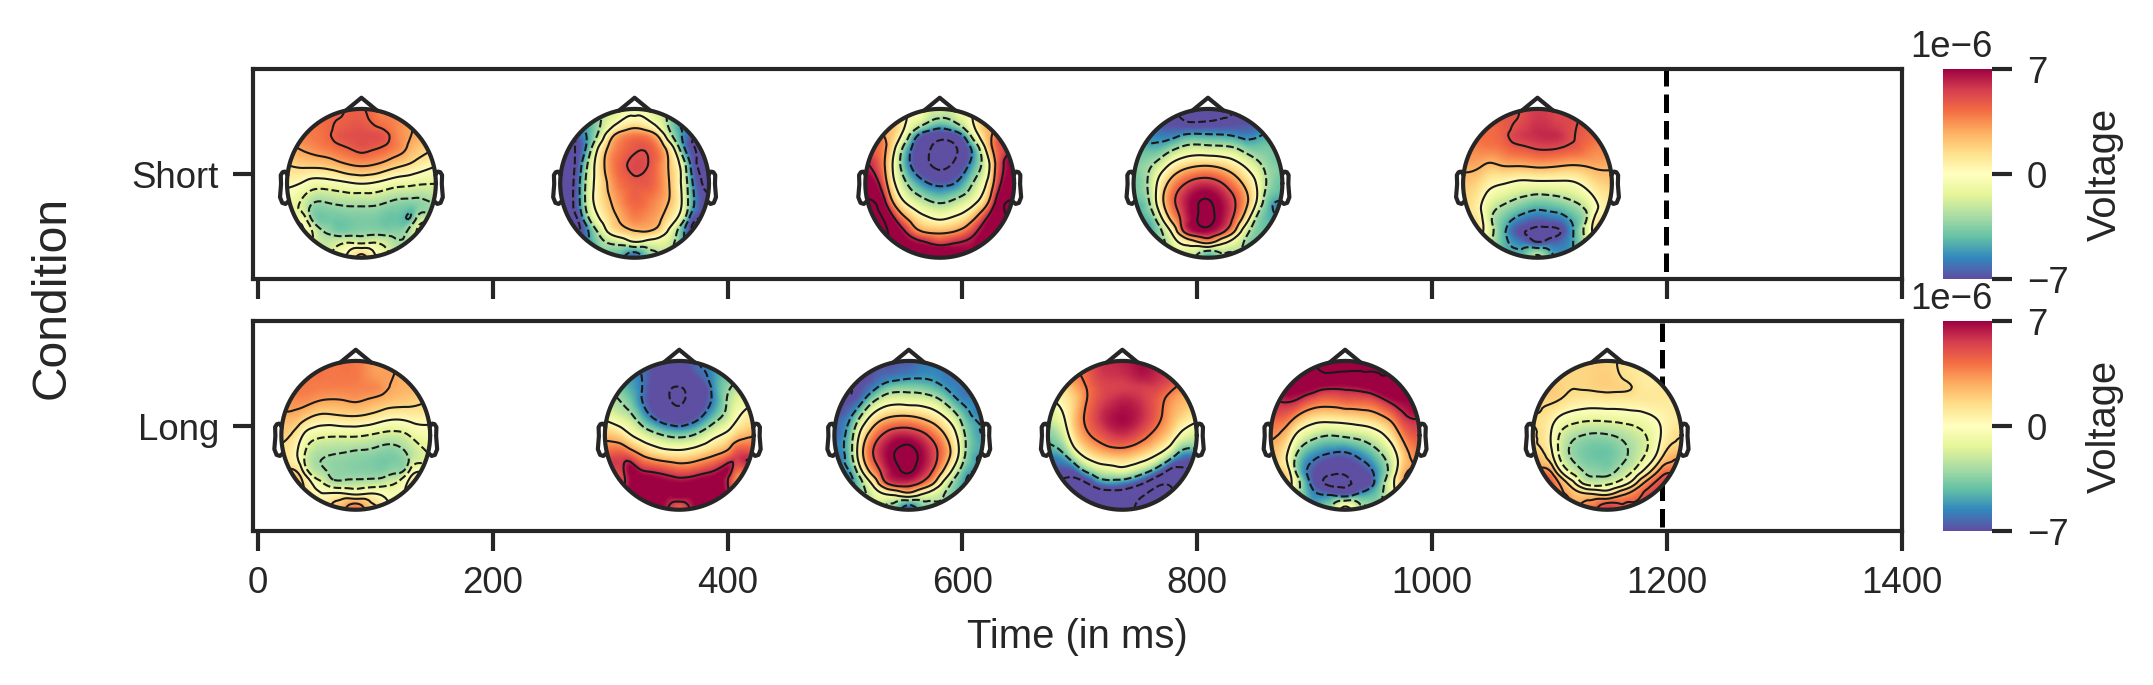

In [30]:
fig_t1, ax_t1 = stage_finder.visualize_model(positions, max_time=1400, figsize=(7.09, 2))

In [ ]:
# fig_t1.savefig("../img/hmp_fit_t1.svg")

In [ ]:
# hmp.utils.save_fit(stage_finder.fits[0], "250hz_t1_short.nc")
# hmp.utils.save_fit(stage_finder.fits[1], "250hz_t1_long.nc")

In [ ]:
# output_path = DATA_PATH / "prp/stage_data_250hz_t1.nc"
# stage_data = stage_finder.label_model(
#     label_fn=stage_finder.__label_model_probabilistic__, probabilistic=True
# )
# stage_data.attrs["task"] = "prp1/t1"

In [ ]:
# stage_data.to_netcdf(output_path)

#### Task 2

In [32]:
cpus = 4

# epoched_data_path = DATA_PATH / "prp/data_t2_250hz_static.nc"

conditions = ["short", "long"]
labels = {"short": ["negative", "t2_1", "t2_2", "t2_3"], "long": ["negative", "t2_1", "t2_2", "t2_3", "t2_4"]}
# pca_weights = xr.load_dataarray("files/train_pca_t2.nc")

stage_finder = StageFinder(
    data_t2,
    labels,
    conditions=conditions,
    cpus=cpus,
    fit_function="fit",  # n_events is extracted from the amount of labels in 'conditions' variable
    verbose=False,
    condition_variable="condition",
    condition_method="equal",
    # fits_to_load=["250hz_t2_short.nc", "250hz_t2_long.nc"],
    n_comp=10,
    event_width=50,
    # pca_weights=pca_weights,
)
stage_finder.fit_model()

Transforming epoched data to principal component (PC) space


/workspace/hmp_repo/hmp/utils.py:539: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model for short condition


  0%|          | 0/303 [00:00<?, ?it/s]

Transition event 1 found around sample 13
Transition event 2 found around sample 121
Transition event 3 found around sample 183
Transition event 4 found around sample 229
Transition event 5 found around sample 245

All events found, refitting final combination.
Estimating 5 events model
parameters estimated for 5 events model
Fitting HMP model for long condition


  0%|          | 0/300 [00:00<?, ?it/s]

Transition event 1 found around sample 14
Transition event 2 found around sample 106
Transition event 3 found around sample 175
Transition event 4 found around sample 203
Transition event 5 found around sample 239
Transition event 6 found around sample 261

All events found, refitting final combination.
Estimating 6 events model
parameters estimated for 6 events model


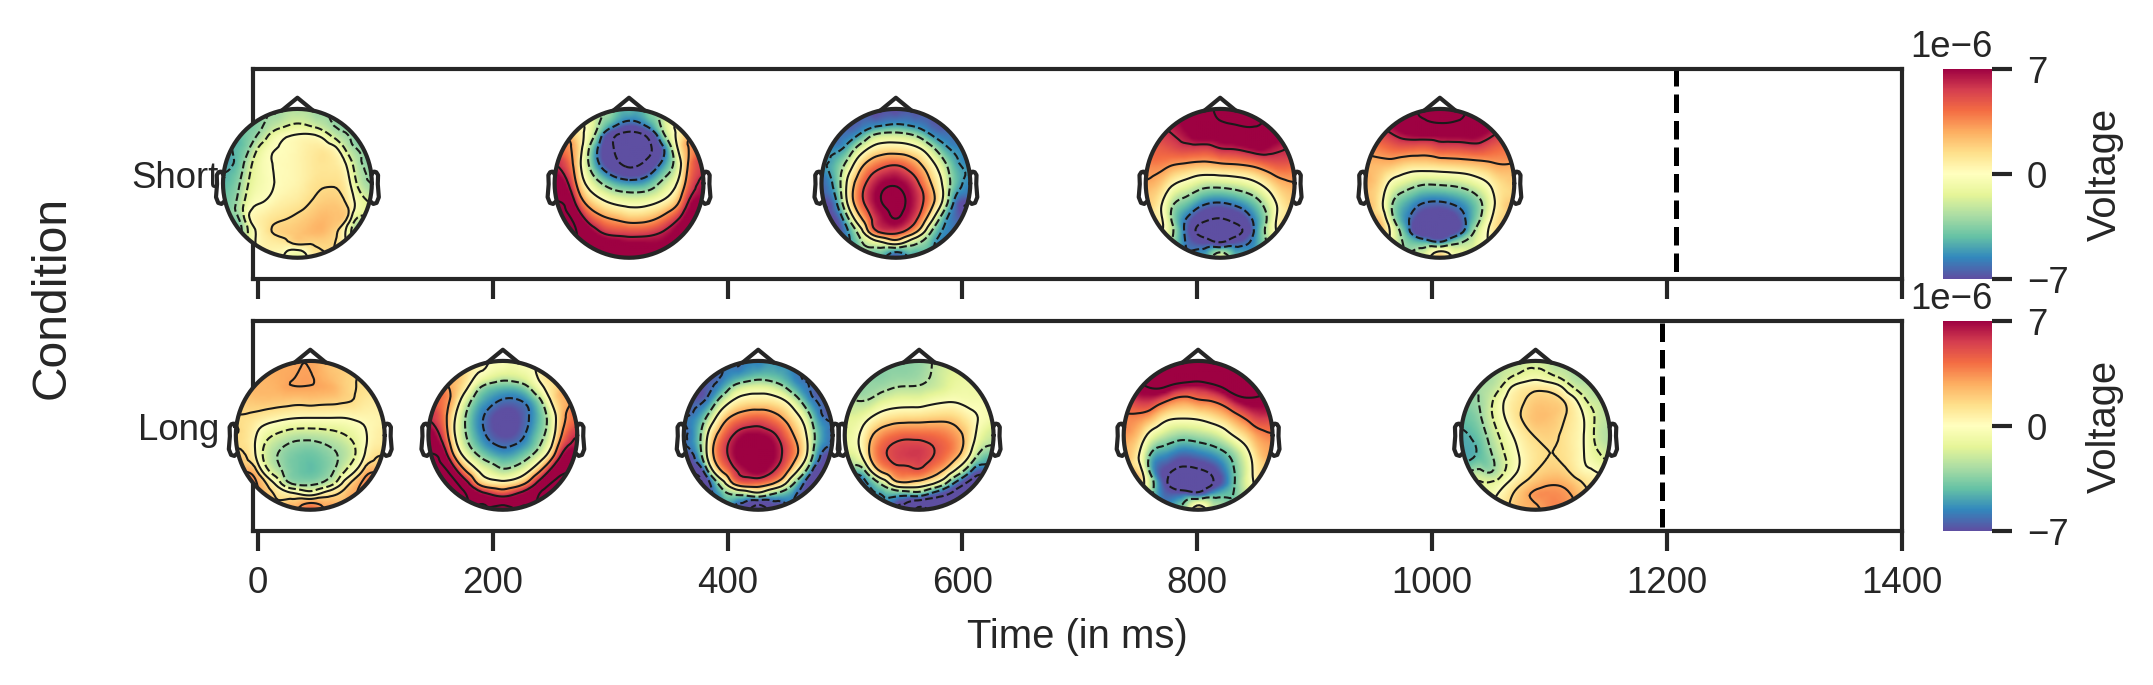

In [33]:
fig_t2, ax_t2 = stage_finder.visualize_model(positions, max_time=1400, figsize=(7.09, 2))

In [12]:
fig_t2.savefig("../img/hmp_fit_t2.svg")

In [13]:
hmp.utils.save_fit(stage_finder.fits[0], "250hz_t2_short.nc")
hmp.utils.save_fit(stage_finder.fits[1], "250hz_t2_long.nc")

250hz_t2_short.nc saved
250hz_t2_long.nc saved


In [ ]:
output_path = DATA_PATH / "prp/stage_data_250hz_t2.nc"
stage_data = stage_finder.label_model(
    label_fn=stage_finder.__label_model_probabilistic__, probabilistic=True
)
stage_data.attrs["task"] = "prp1/t2"

Labeling dataset for short condition
Processing participant VP1
Processing participant VP10
Processing participant VP11
Processing participant VP12
Processing participant VP13
Processing participant VP14
Processing participant VP15
Processing participant VP16
Processing participant VP17
Processing participant VP18
Processing participant VP19
Processing participant VP2
Processing participant VP20
Processing participant VP21
Processing participant VP22
Processing participant VP23
Processing participant VP24
Processing participant VP3
Processing participant VP5
Processing participant VP8
Processing participant VP9
Labeling dataset for long condition
Processing participant VP1
Processing participant VP10
Processing participant VP11
Processing participant VP12
Processing participant VP13
Processing participant VP14
Processing participant VP15
Processing participant VP16
Processing participant VP17
Processing participant VP18
Processing participant VP19
Processing participant VP2
Processing 

In [15]:
stage_data.to_netcdf(output_path)

### Event widths

In [ ]:
ew_values = [20, 25, 30, 35, 40, 45, 50, 55, 60]

In [ ]:
cpus = 4

epoched_data_path = DATA_PATH / "prp/data_t1_250hz.nc"

# TODO: Conditions + labels
conditions = ["short", "long"]
labels = {"short": ["negative", "t1_1", "t1_2", "t1_3", "t1_4"], "long": ["negative", "t1_1", "t1_2", "t1_3", "t1_4"]}

for event_width in ew_values:
    stage_finder = StageFinder(
        epoched_data_path,
        labels,
        conditions=conditions,
        cpus=cpus,
        fit_function="fit",  # n_events is extracted from the amount of labels in 'conditions' variable
        verbose=False,
        condition_variable="condition",
        condition_method="equal",
        # fits_to_load=["250hz_t1_short.nc", "250hz_t1_long.nc"],
        n_comp=10,
        event_width=event_width,
    )
    # Retraining model with smaller window
    stage_finder.fit_model()
    fig, ax = stage_finder.visualize_model(positions, max_time=700, figsize=(12, 3))
    fig.savefig(f"../img/event_width/hmp_fit_t1_{str(event_width)}.svg")

In [ ]:
cpus = 4

epoched_data_path = DATA_PATH / "prp/data_t2_250hz.nc"

# TODO: Conditions + labels
conditions = ["short", "long"]
labels = {"short": ["negative", "t2_1", "t2_2", "t2_3"], "long": ["negative", "t2_1", "t2_2", "t2_3"]}

for event_width in ew_values:
    stage_finder = StageFinder(
        epoched_data_path,
        labels,
        conditions=conditions,
        cpus=cpus,
        fit_function="fit",  # n_events is extracted from the amount of labels in 'conditions' variable
        verbose=False,
        condition_variable="condition",
        condition_method="equal",
        # fits_to_load=["250hz_t2_short.nc", "250hz_t2_long.nc"],
        n_comp=10,
        event_width=event_width,
    )
    # Retraining model with smaller window
    stage_finder.fit_model()
    fig, ax = stage_finder.visualize_model(positions, max_time=700, figsize=(12, 3))
    fig.savefig(f"../img/event_width/hmp_fit_t2_{str(event_width)}.svg")

### Add 'task' attribute

In [3]:
ds = xr.load_dataset(DATA_PATH / "prp/stage_data_250hz_t2.nc")
ds.attrs['task'] = 'prp1/t2'
ds.to_netcdf(DATA_PATH / "prp/stage_data_250hz_t2.nc")

In [ ]:
ds = xr.load_dataset(DATA_PATH / "prp/stage_data_250hz_t1.nc")
ds.attrs['task'] = 'prp1/t1'
ds.to_netcdf(DATA_PATH / "prp/stage_data_250hz_t1.nc")